# Visium HD dataset

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanorama


## Run the single-cell dataset through the Seurat analysis until we get clusters

In [2]:
sc_dataset_id = "2a25e445-2776-8913-076f-9a147a43e8b4"  # P7, mouse, scRNA-seq, cochlea (Kelley)
h5_path = "../www/datasets/{}.h5ad".format(sc_dataset_id)
adata = sc.read_h5ad(h5_path)

# Already had primary analysis done

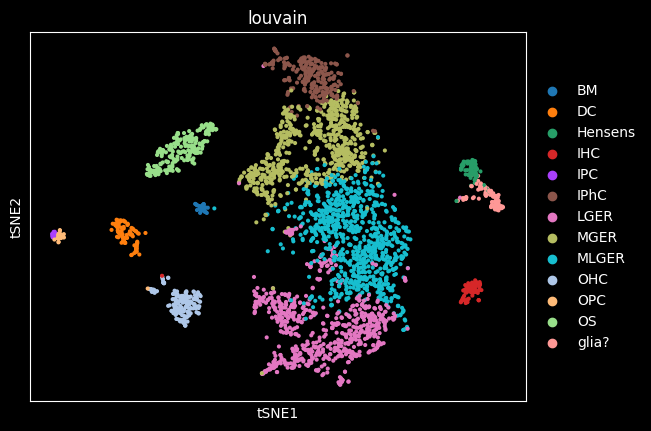

In [3]:
sc.pl.tsne(adata, color=["louvain"])


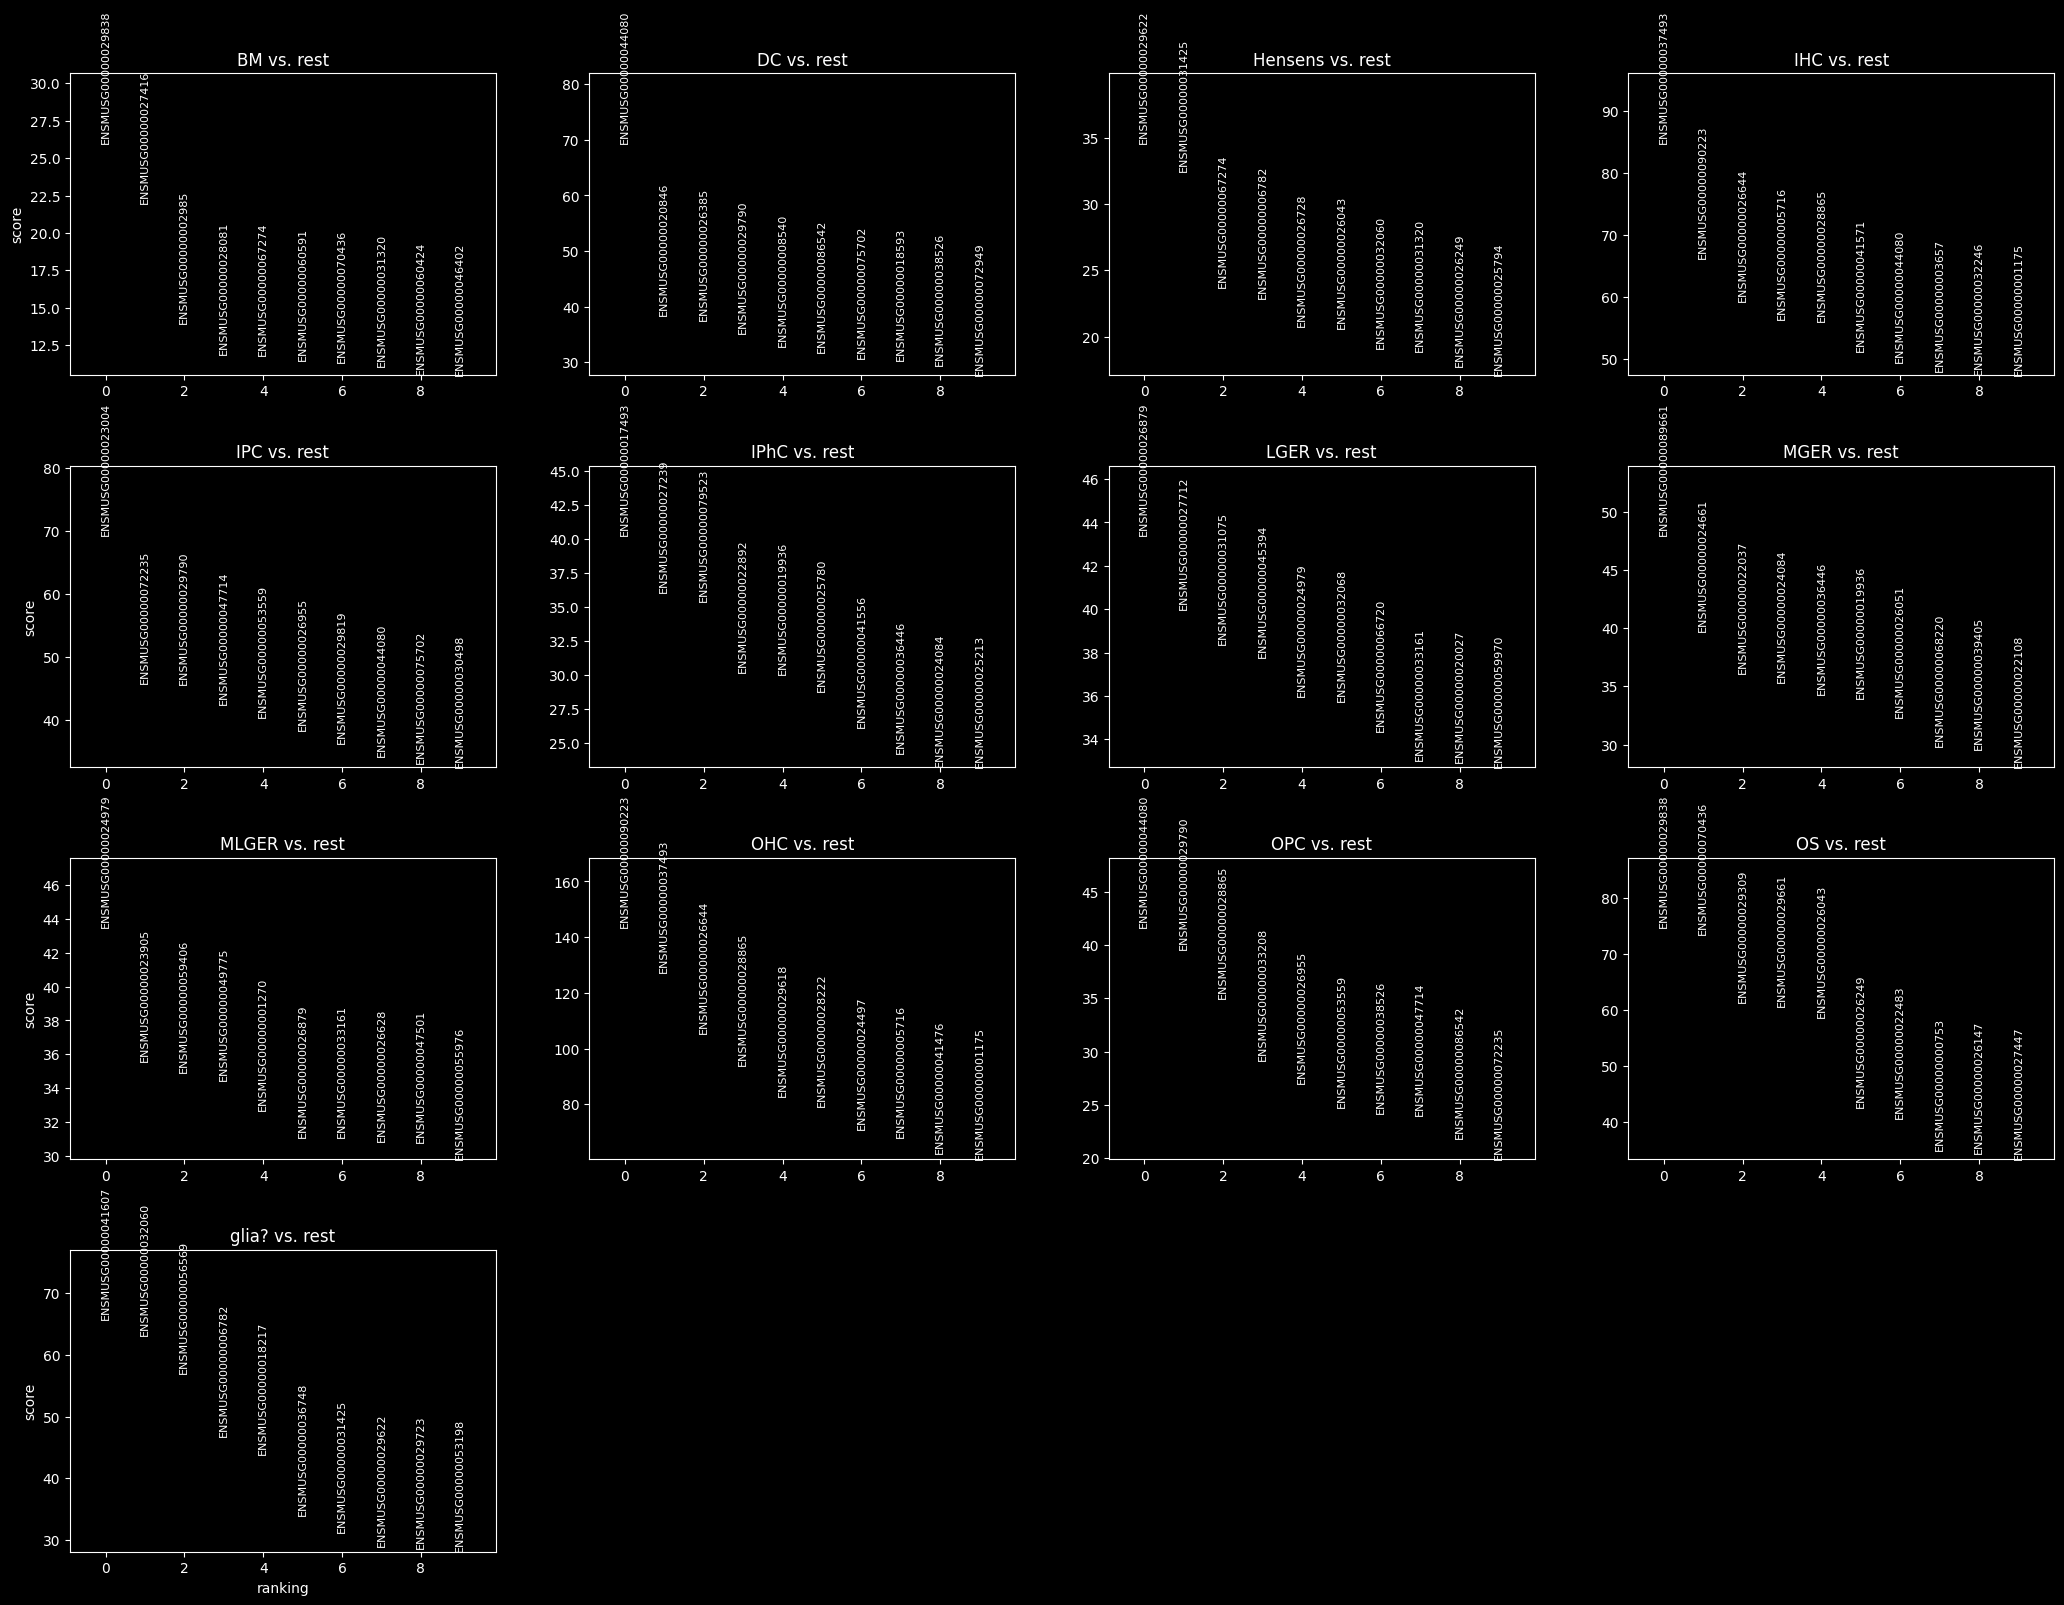

In [4]:
sc.tl.rank_genes_groups(adata, "louvain", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [5]:
sc.tl.filter_rank_genes_groups(adata, min_fold_change=2)
adata.uns["rank_genes_groups_filtered"]


{'params': {'groupby': 'louvain',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([(nan, nan, 'ENSMUSG00000029622', 'ENSMUSG00000037493', 'ENSMUSG00000023004', 'ENSMUSG00000017493', nan, nan, nan, 'ENSMUSG00000090223', nan, nan, 'ENSMUSG00000041607'),
            ('ENSMUSG00000027416', 'ENSMUSG00000020846', 'ENSMUSG00000031425', 'ENSMUSG00000090223', nan, nan, nan, nan, nan, 'ENSMUSG00000037493', 'ENSMUSG00000029790', nan, 'ENSMUSG00000032060'),
            ('ENSMUSG00000002985', nan, nan, 'ENSMUSG00000026644', 'ENSMUSG00000029790', nan, 'ENSMUSG00000031075', nan, nan, 'ENSMUSG00000026644', 'ENSMUSG00000028865', 'ENSMUSG00000029309', 'ENSMUSG00000056569'),
            ...,
            (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
            (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
            (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [6]:
#all_marker_genes_df = pd.DataFrame(adata.uns["rank_genes_groups_filtered"]["names"])

#marker_genes_df = pd.DataFrame()

# select the top 10 non-nan marker genes for each cluster
#for cluster in adata.obs["louvain"].cat.categories:
#    marker_genes_s = all_marker_genes_df[cluster].dropna().head(10)
#    marker_genes_df[cluster] = marker_genes_s.reset_index(drop=True)

#marker_genes_df


In [7]:
all_marker_genes_df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
marker_genes_df = all_marker_genes_df.head(10)

In [8]:
# Convert marker_genes_df to a binary dataframe where the rows are the marker genes and the columns are the clusters
# and the values are 1 if the marker gene is in the cluster and 0 otherwise

marker_genes_set  = set(marker_genes_df.values.flatten())

binary_gene_list_df = pd.DataFrame(0, index=list(marker_genes_set), columns=adata.obs["louvain"].cat.categories)
for cluster in adata.obs["louvain"].cat.categories:
    binary_gene_list_df.loc[marker_genes_df[cluster], cluster] = 1

# filter out nan index values in case there are less than 10 filtered marker genes
binary_gene_list_df = binary_gene_list_df[binary_gene_list_df.index.notnull()]

# column 2 should included the gene symbol associated with the indexed ensembl id
binary_gene_list_df["gene_symbol"] = binary_gene_list_df.index.map(lambda x: adata.var.loc[x, "gene_symbol"])

# reorder columns where gene_symbol is first
cols = binary_gene_list_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
binary_gene_list_df = binary_gene_list_df[cols]

binary_gene_list_df

,gene_symbol,BM,DC,Hensens,IHC,IPC,IPhC,LGER,MGER,MLGER,OHC,OPC,OS,glia?
ENSMUSG00000029622,Arpc1b,0,0,1,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000024661,Fth1,0,0,0,0,0,0,0,1,0,0,0,0,0
ENSMUSG00000003657,Calb2,0,0,0,1,0,0,0,0,0,0,0,0,0
ENSMUSG00000027712,Anxa5,0,0,0,0,0,0,1,0,0,0,0,0,0
ENSMUSG00000008540,Mgst1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000090223,Pcp4,0,0,0,1,0,0,0,0,0,1,0,0,0
ENSMUSG00000027416,Otor,1,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000025794,Rpl14,0,0,1,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000072235,Tuba1a,0,0,0,0,1,0,0,0,0,0,1,0,0


In [9]:
# all genes
orig_all_marker_genes_df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

all_marker_genes_set  = set(orig_all_marker_genes_df.values.flatten())

#z_scores = pd.DataFrame(adata.uns["rank_genes_groups_filtered"]["scores"])
z_scores = pd.DataFrame(adata.uns["rank_genes_groups"]["scores"])


weighted_gene_list_df = pd.DataFrame(data=z_scores.to_numpy(), index=list(all_marker_genes_set), columns=adata.obs["louvain"].cat.categories)

# column 2 should included the gene symbol associated with the indexed ensembl id
weighted_gene_list_df["gene_symbol"] = weighted_gene_list_df.index.map(lambda x: adata.var.loc[x, "gene_symbol"])

# reorder columns where gene_symbol is first
cols = weighted_gene_list_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
weighted_gene_list_df = weighted_gene_list_df[cols]

weighted_gene_list_df

,gene_symbol,BM,DC,Hensens,IHC,IPC,IPhC,LGER,MGER,MLGER,OHC,OPC,OS,glia?
ENSMUSG00000062488,Ifit3b,26.011190,69.446625,34.594326,84.800224,69.355278,40.304146,43.413303,47.990307,43.483368,143.497864,41.690781,74.815117,65.728821
ENSMUSG00000054814,Usp46,21.956736,38.377335,32.443466,66.287987,45.860878,36.052578,39.974586,39.695694,35.563339,127.211678,39.620995,73.595215,63.231537
ENSMUSG00000036867,Smad6,13.925958,37.587360,23.665606,59.282501,45.589088,35.452888,38.397034,36.101082,34.911304,105.475739,34.976910,61.390030,56.948559
ENSMUSG00000107994,D830050J10Rik,11.912612,35.233124,22.881481,56.462009,42.526321,30.168537,37.788780,35.348347,34.440033,93.874336,29.113977,60.606686,46.749332
ENSMUSG00000002778,Kdelr1,11.785747,32.926147,20.765577,56.079533,40.327866,30.015028,35.973969,34.343143,32.703098,82.840477,26.989660,58.620697,43.922348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000049739,Zfp646,-17.962517,-30.372902,-47.122047,-42.208473,-46.188999,-24.695190,-26.611595,-21.139133,-21.125801,-54.203102,-41.052307,-60.719650,-43.003910
ENSMUSG00000024528,Srfbp1,-18.311049,-30.586393,-49.422054,-42.449478,-48.007809,-24.769772,-27.659681,-22.842966,-23.443329,-54.733055,-42.439995,-63.034065,-45.113621
ENSMUSG00000027201,Myef2,-18.514061,-33.177307,-49.597649,-43.366417,-48.675896,-27.388933,-28.972588,-23.747208,-23.770611,-60.174671,-44.121578,-65.936943,-45.703918
ENSMUSG00000074384,AI429214,-18.567232,-33.719257,-52.563988,-46.532417,-52.433228,-28.125324,-29.171398,-28.207315,-24.578011,-61.599915,-44.295685,-68.638710,-53.395271


## Normalize the spatial dataset

In [2]:

# Had to symlink to image paths into the "spatial" directory within visium_dataset_path
# These are Postnatal Day 7, Wild-type, CD-1 IGS Mice from Charles River

import spatialdata_io as sdio
from spatialdata_io.experimental import to_legacy_anndata

visium_dataset_path = "../Shults_SpatialData/binned_outputs/square_008um"
count_file = "{}/filtered_feature_bc_matrix.h5".format(visium_dataset_path)

/opt/homebrew/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
# Convert tissue position parquet file into csv so it can be read by scanpy read_visium function

import pandas as pd
df = pd.read_parquet("{}/spatial/tissue_positions.parquet".format(visium_dataset_path))
df.to_csv("{}/spatial/tissue_positions_list.csv".format(visium_dataset_path), index=False)

In [12]:
#vis_adata = sc.read_visium(visium_dataset_path)
#vis_adata

In [4]:
#vis_adata = sc.read_visium(visium_dataset_path)
vis_sdata = sdio.visium(visium_dataset_path, dataset_id="D1")    # visium_hd function does not work (no inferred dataset id)
vis_sdata

INFO     reading ../Shults_SpatialData/binned_outputs/square_008um/filtered_feature_bc_matrix.h5                   


/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/spatialdata_io/readers/visium.py:155: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  coords = pd.read_csv(tissue_positions_file, header=None, index_col=0)
/opt/homebrew/lib/python3.12/site-packages/spatialdata/models/models.py:1035: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


SpatialData object
├── Images
│     ├── 'D1_hires_image': DataArray[cyx] (3, 3866, 6000)
│     └── 'D1_lowres_image': DataArray[cyx] (4, 3000, 3200)
├── Shapes
│     └── 'D1': GeoDataFrame shape: (97750, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (97750, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        D1_hires_image (Images), D1 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        D1_lowres_image (Images), D1 (Shapes)
    ▸ 'global', with elements:
        D1 (Shapes)

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.4615763168012303..3.2598385236447522].


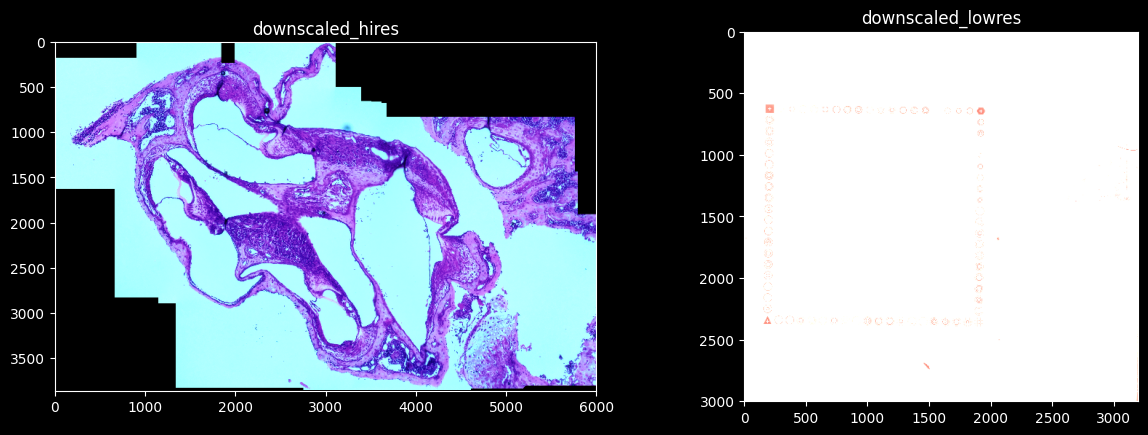

In [5]:
import spatialdata_plot
vis_sdata.pl.render_images().pl.show()



In [ ]:
# Bounding box query to only get the hires part of the entire image. This should hopefully yield a better result

from spatialdata import bounding_box_query

img_to_use = "D1_hires_image"
x = len(vis_sdata.images[img_to_use].x)
y = len(vis_sdata.images[img_to_use].y)

vis_sdata = bounding_box_query(vis_sdata,
                           axes=("x", "y"),
                           min_coordinate=[0, 0],
                           max_coordinate=[x, y],
                           #min_coordinate=[1000, 1000],
                           #max_coordinate=[2000, 2000], # think this is the Organ of Corti region, according to Chris.  Need to verify
                           #max_coordinate=[x, y],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )

"""
# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object
query = bounding_box_query(vis_sdata["D1_hires_image"],
                           axes=("x", "y"),
                           min_coordinate=[0, 0],
                           max_coordinate=[3000, 3000],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )

vis_sdata["query"] = query
vis_sdata.pl.render_images("query").pl.show()
query.pl.render_images("D1_hires_image").pl.show()
"""
vis_sdata.pl.render_images().pl.show()

'\n# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object\nquery = bounding_box_query(vis_sdata["D1_hires_image"],\n                           axes=("x", "y"),\n                           min_coordinate=[0, 0],\n                           max_coordinate=[3000, 3000],\n                           target_coordinate_system="downscaled_hires",\n                           filter_table=True,\n                           )\n\nvis_sdata["query"] = query\nvis_sdata.pl.render_images("query").pl.show()\nquery.pl.render_images("D1_hires_image").pl.show()\n'

In [637]:
vis_sdata

SpatialData object
├── Images
│     └── 'D1_hires_image': DataArray[cyx] (3, 1000, 1000)
├── Shapes
│     └── 'D1': GeoDataFrame shape: (2401, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2401, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        D1_hires_image (Images), D1 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        D1 (Shapes)
    ▸ 'global', with elements:
        D1 (Shapes)

In [638]:
vis_adata = to_legacy_anndata(vis_sdata, include_images=True, coordinate_system="downscaled_hires")
vis_adata

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 1.98594602e+00  0.00000000e+00 -1.97089205e+03]                                                 
          [ 0.00000000e+00  1.98585814e+00 -1.98032102e+03]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[1.98594602 1.98585814]                                                                       
         scale_factor=1.985902082465071                                                                            
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

AnnData object with n_obs × n_vars = 2401 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

In [639]:
vis_adata.var_names_make_unique()

# currently gene symbols are the index, need to move them to a column
vis_adata.var["gene_symbol"] = vis_adata.var.index

# set the index to the ensembl id (gene_ids)
vis_adata.var.set_index("gene_ids", inplace=True)

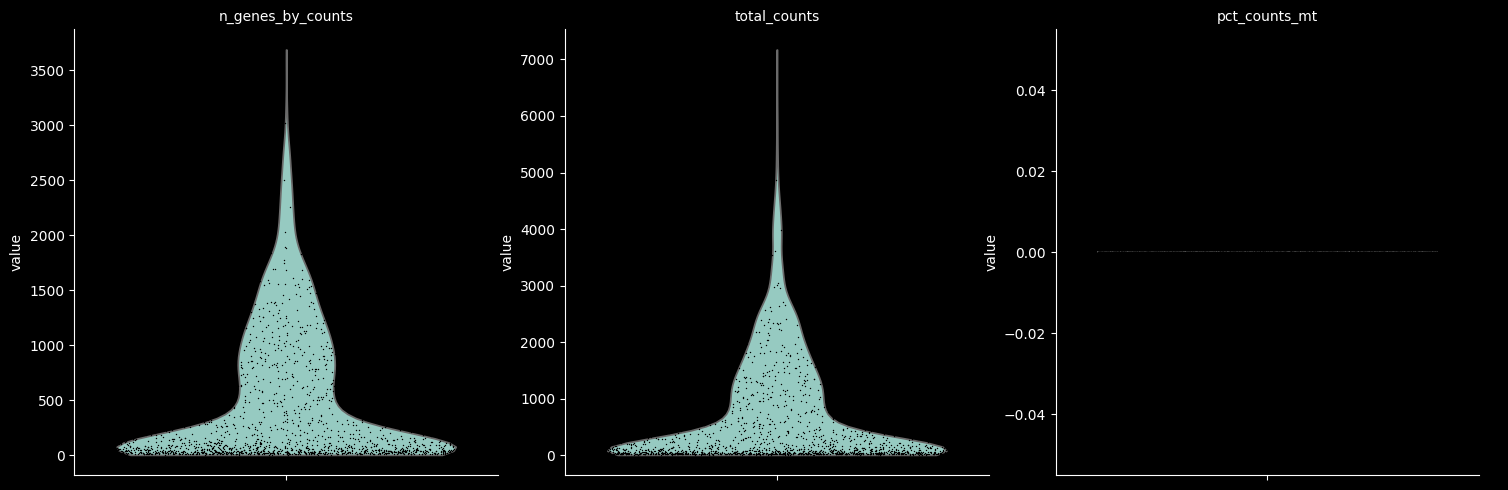

In [640]:
vis_adata.var["mt"] = vis_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(vis_adata, qc_vars=["mt"], inplace=True)
sc.pl.violin(
    vis_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [641]:
sc.pp.filter_cells(vis_adata, min_genes=300)
sc.pp.normalize_total(vis_adata, inplace=True)
sc.pp.log1p(vis_adata)
sc.pp.highly_variable_genes(vis_adata, flavor="seurat", n_top_genes=2000, inplace=True)

In [642]:
vis_adata.var.head()

,feature_types,genome,gene_symbol,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
gene_ids,,,,,,,,,,,,,,
ENSMUSG00000051951,Gene Expression,mm10,Xkr4,False,17,0.007497,0.007469,99.291962,18.0,2.944439,False,0.012717,0.169114,0.043874
ENSMUSG00000025900,Gene Expression,mm10,Rp1,False,8,0.003332,0.003326,99.666805,8.0,2.197225,False,0.004758,0.207448,0.134643
ENSMUSG00000025902,Gene Expression,mm10,Sox17,False,40,0.017909,0.017751,98.334027,43.0,3.784190,False,0.034624,0.463166,0.740149
ENSMUSG00000025903,Gene Expression,mm10,Lypla1,False,124,0.058309,0.056672,94.835485,140.0,4.948760,False,0.101562,0.500460,0.828456
ENSMUSG00000033813,Gene Expression,mm10,Tcea1,False,233,0.119534,0.112912,90.295710,287.0,5.662961,False,0.165577,0.269555,-0.599710


### Scanorama cluster predictions

In [643]:
adatas = [adata, vis_adata]
vis_adata_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 14248 genes among all datasets
[[0.         0.58024691]
 [0.         0.        ]]
Processing datasets (0, 1)


In [644]:
vis_adata_cor
# two adata objects are returned, the first is the corrected single-cell adata object and the second is the corrected visium adata object

# The X_scanorama attribute in each object contains the low dimensional embeddings as a result of integration, which can be used for KNN graph construction

[AnnData object with n_obs × n_vars = 3413 × 14248
     obs: 'cell_type', 'tSNE_1', 'tSNE_2', 'replicate', 'louvain'
     var: 'gene_symbol'
     uns: 'louvain_colors', 'rank_genes_groups', 'rank_genes_groups_filtered'
     obsm: 'X_tsne', 'X_scanorama',
 AnnData object with n_obs × n_vars = 1215 × 14248
     obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
     var: 'feature_types', 'genome', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial', 'spatialdata_attrs', 'log1p', 'hvg'
     obsm: 'spatial', 'X_scanorama']

In [645]:
vis_adata_concat = sc.concat(
    vis_adata_cor,
    label="dataset",
    keys=["single-cell", "visium"],
    join="outer",
    uns_merge="first",
)

In [646]:
# the "dataset" label this is added to the obs column is used to distinguish between the single-cell and visium datasets
vis_adata_concat

AnnData object with n_obs × n_vars = 4628 × 14248
    obs: 'cell_type', 'tSNE_1', 'tSNE_2', 'replicate', 'louvain', 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'dataset'
    uns: 'louvain_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'spatial', 'spatialdata_attrs', 'log1p', 'hvg'
    obsm: 'X_tsne', 'X_scanorama', 'spatial'

In [647]:
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    vis_adata_concat[vis_adata_concat.obs.dataset == "single-cell"].obsm[
        "X_scanorama"
    ],
    vis_adata_concat[vis_adata_concat.obs.dataset == "visium"].obsm[
        "X_scanorama"
    ],
)
distances.shape

(3413, 1215)

In [648]:
def label_transfer(dist, labels):
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

# Need to use the louvain from the single-cell dataset to match the n_obs of the distances matrix position 0
class_prob = label_transfer(distances, adata.obs.louvain)

# output is the probability of each cluster for each spatial location
class_prob.shape


(1215, 13)

In [649]:
# for each spatial location, find the cluster with the highest probability
# this is the predicted cluster for each spatial location
predicted_clusters = np.argmax(class_prob, axis=1)

# predicted_clusters is a numpy array of index positions used to index into the adata.obs.louvain.cat.categories
# to get the actual cluster names

# add the predicted clusters to the visium adata object

vis_adata.obs["scanorama_predicted_clusters"] = pd.Categorical(
    [adata.obs.louvain.cat.categories[i] for i in predicted_clusters]
)
vis_adata.obs


,in_tissue,array_row,array_col,spot_id,region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,scanorama_predicted_clusters
s_008um_00434_00169-1,1,434,169,75,D1,1159,7.056175,1464.0,7.289610,15.437158,22.267760,34.494536,54.986339,0.0,0.0,0.0,1159,IPhC
s_008um_00439_00174-1,1,439,174,147,D1,837,6.731018,1187.0,7.080027,26.958719,35.383319,46.335299,71.609099,0.0,0.0,0.0,837,OS
s_008um_00456_00172-1,1,456,172,335,D1,682,6.526495,819.0,6.709304,20.512821,28.937729,41.147741,77.777778,0.0,0.0,0.0,682,OS
s_008um_00433_00149-1,1,433,149,451,D1,316,5.758902,402.0,5.998937,33.830846,46.268657,71.144279,100.000000,0.0,0.0,0.0,316,OS
s_008um_00465_00146-1,1,465,146,496,D1,1111,7.013915,1555.0,7.349874,21.736334,29.196141,41.414791,60.707395,0.0,0.0,0.0,1111,OS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00453_00167-1,1,453,167,97292,D1,2162,7.679251,4340.0,8.375860,19.677419,25.714286,34.493088,52.188940,0.0,0.0,0.0,2162,MLGER
s_008um_00481_00169-1,1,481,169,97354,D1,783,6.664409,1043.0,6.950815,22.339406,31.927133,44.103547,72.866731,0.0,0.0,0.0,783,OS
s_008um_00477_00169-1,1,477,169,97442,D1,773,6.651572,967.0,6.875232,18.924509,29.265770,40.744571,71.768356,0.0,0.0,0.0,773,OS
s_008um_00460_00166-1,1,460,166,97468,D1,1719,7.450080,2301.0,7.741534,11.429813,17.948718,27.031725,47.023033,0.0,0.0,0.0,1719,BM


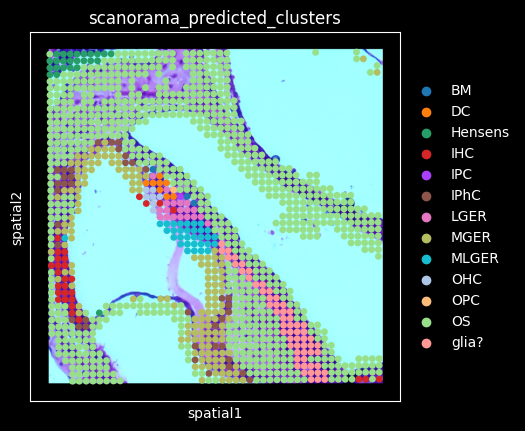

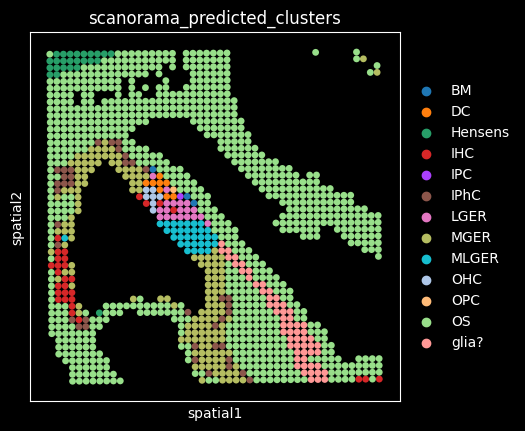

In [650]:
# The "D1_hires_image" key is used to access the image paths in the "spatial" directory. Using "D1" throws an error because no images are stored there I guess.
sc.pl.spatial(vis_adata, color="scanorama_predicted_clusters", img_key="hires", library_id="D1_hires_image")
sc.pl.spatial(vis_adata, color="scanorama_predicted_clusters", img_key=None, library_id="D1_hires_image")

In [651]:
vis_adata.obs.value_counts("scanorama_predicted_clusters")

scanorama_predicted_clusters
OS         845
MGER       148
glia?       58
IPhC        39
MLGER       32
IHC         29
Hensens     25
LGER        19
DC           8
OHC          7
BM           3
IPC          1
OPC          1
Name: count, dtype: int64

In [652]:
vis_adata.uns["spatial"]

{'D1': {'metadata': {'chemistry_description': 'Visium HD v1',
   'software_version': 'spaceranger-3.0.0'}},
 'D1_hires_image': {'images': {'hires': array([[[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          ...,
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
           ...,
           [0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],
   
          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0],
     

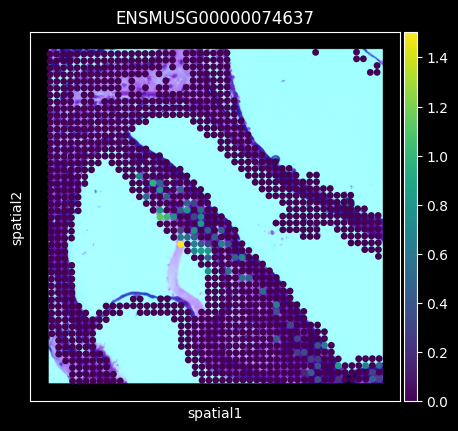

In [653]:
gene = adata.var[adata.var.gene_symbol == "Sox2"].index[0]
sc.pl.spatial(vis_adata, color=gene, img_key="hires", library_id="D1_hires_image")


### Leiden clustering on spatial dataset

In [654]:
sc.pp.pca(vis_adata)
sc.pp.neighbors(vis_adata)
sc.tl.tsne(vis_adata)

# I keep adjusting until the resolution setting makes clusters roughly match the single-cell clusters
sc.tl.leiden(
    vis_adata, key_added="spatial_clusters", flavor="igraph", directed=False
)

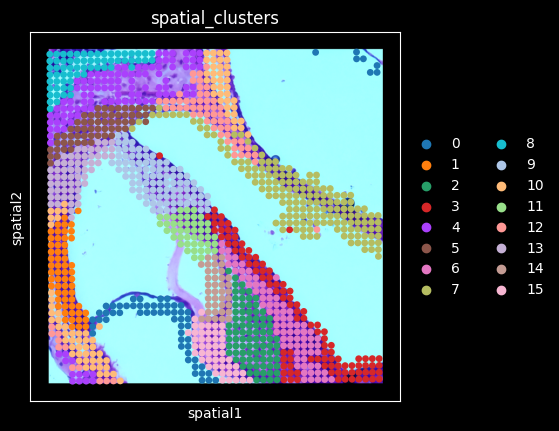

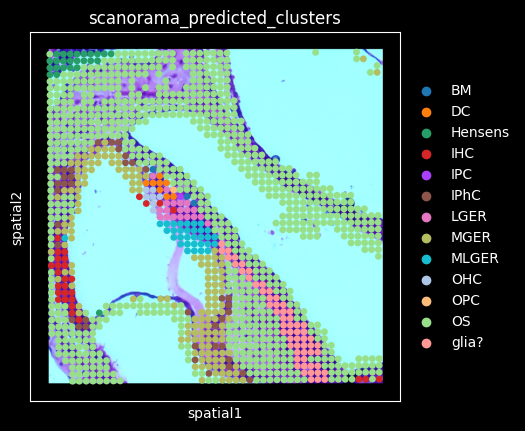

In [655]:
sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="D1_hires_image")
sc.pl.spatial(vis_adata, img_key="hires", color="scanorama_predicted_clusters", size=1, library_id="D1_hires_image")


### ProjectR cluster transferrence

In [656]:
# Drop the gene symbol column
#loading_df = weighted_gene_list_df.drop(weighted_gene_list_df.columns[0], axis=1)

loading_df = binary_gene_list_df.drop(binary_gene_list_df.columns[0], axis=1)


# Drop duplicate unique identifiers. This may happen if two unweighted gene cart genes point to the same Ensembl ID in the db
loading_df = loading_df[~loading_df.index.duplicated(keep='first')]


num_target_genes = vis_adata.shape[1]
num_loading_genes = loading_df.shape[0]

# Perform overlap to see if there are overlaps between genes from both dataframes
index_intersection = vis_adata.var.index.intersection(loading_df.index)
intersection_size = index_intersection.size
intersection_size

88

In [657]:
# Reduce the size of both dataframes before POSTing
projection_vis_adata = vis_adata[:,index_intersection]
target_df = projection_vis_adata.to_df().transpose()
loading_df = loading_df.loc[index_intersection]

In [658]:
def calculate_chunk_size(num_genes, num_samples):
    """
    Calculate number of chunks to divide all samples into.
    """
    TOTAL_DATA_LIMIT = 6e6  # normally 1e6
    total_data = num_genes * num_samples
    total_data_chunks = total_data / TOTAL_DATA_LIMIT
    return int(num_samples / total_data_chunks) # ta

# Chunk size needs to adjusted by how many genes are present, so that the payload always stays under the body size limit
chunk_size = calculate_chunk_size(len(target_df.index), len(target_df.columns))

In [659]:
import asyncio
import aiohttp
from more_itertools import sliced

projectr_url = "https://staging---projectr-service-ruvt5l3uva-uk.a.run.app"

# limit of asynchronous tasks that can happen at a time
# I am setting this slightly under the "MaxKeepAliveRequests" in apache.conf
SEMAPHORE_LIMIT = 50

import sys, os
lib_path = os.path.abspath(os.path.join('..', 'lib'))
sys.path.append(lib_path)

# https://stackoverflow.com/a/35904211/1368079
this = sys.modules[__name__]
from gear.serverconfig import ServerConfig
this.servercfg = ServerConfig().parse()

def chunk_dataframe(df, chunk_size):
    # Chunk dataset by samples/cells (cols). Is a generator function
    # Help from: https://stackoverflow.com/questions/51674751/using-requests-library-to-make-asynchronous-requests-with-python-3-7
    index_slices = sliced(range(len(df.columns)), chunk_size)
    print("Number of slices: ", len(df.columns) / chunk_size)
    for idx, index_slice in enumerate(index_slices):
        yield df.iloc[:,index_slice]


async def fetch_all(target_df, loading_df, algo, chunk_size):
    """Create coroutine tasks out of all chunked projection cloud run service POST requests."""

    async with aiohttp.ClientSession() as client:
        # Create coroutines to be executed.
        loadings_json = loading_df.to_json(orient="split")
        coros = (fetch_one(client, {
                "target": chunk_df.to_json(orient="split")
                , "loadings": loadings_json
                , "algorithm": algo
                , "genecart_id":"1234" # This helps in identifying which combinations are going through
                , "dataset_id":"abcde"
                }) for chunk_df in chunk_dataframe(target_df, chunk_size))

        # This loop processes results as they come in.
        return [await res for res in limited_as_completed(coros, SEMAPHORE_LIMIT)]

async def fetch_one(client, payload):
    """
    makes an non-authorized POST request to the specified HTTP endpoint
    """

    # brief sleep
    await asyncio.sleep(1)


    # Cloud Run uses your service's hostname as the `audience` value
    # audience = 'https://my-cloud-run-service.run.app/'
    # For Cloud Run, `endpoint` is the URL (hostname + path) receiving the request
    # endpoint = 'https://my-cloud-run-service.run.app/my/awesome/url'

    audience=this.servercfg['projectR_service']['hostname']
    endpoint="{}/".format(audience)
    headers = {"content_type": "application/json"}

    # https://docs.aiohttp.org/en/stable/client_reference.html
    # (semaphore) https://stackoverflow.com/questions/40836800/python-asyncio-semaphore-in-async-await-function
    async with client.post(url=endpoint, json=payload, headers=headers, raise_for_status=True) as response:
        return await response.json()

def limited_as_completed(coros, limit):
    """A version of asyncio.as_completed that takes a generator of coroutines instead of a list."""
    # Source: https://www.artificialworlds.net/blog/2017/05/31/python-3-large-numbers-of-tasks-with-limited-concurrency/
    # Uses far less memory than the list version (asyncio.as_completed)
    from itertools import islice
    futures = {
        asyncio.ensure_future(c)
        for c in islice(coros, 0, limit)
    }
    async def first_to_finish():
        nonlocal futures
        # Suggested by commenter "ruslan" in the URL. Using "while True" can be CPU-intensive
        done, futures = await asyncio.wait(futures, return_when=asyncio.FIRST_COMPLETED)
        # then re-fill the set of futures from the coros iterable
        try:
            newf = next(coros)
            futures.add(
                asyncio.ensure_future(newf))
        except StopIteration as e:
            pass
        # Pass the new done results back
        return done.pop().result()

    while futures:
        yield first_to_finish()

In [660]:
# Jupyter notebooks already run in an event loop, so we can just use the current event loop
results = await fetch_all(target_df, loading_df, "nmf", chunk_size)

Number of slices:  0.017820213842566112


In [661]:
def concat_fetch_results_to_dataframe(res_jsons):
    # Concatenate the dataframes back together again
    res_dfs = [pd.read_json(res_json, orient="split", dtype="float32") for res_json in res_jsons]
    projection_patterns_df = pd.concat(res_dfs)
    return projection_patterns_df

projection_patterns_df = concat_fetch_results_to_dataframe(results)
# There is a good chance the samples are now out of order, which will break
# the copying of the dataset observation metadata when this output is converted
# to an AnnData object. So reorder back to dataset sample order.
projection_patterns_df = projection_patterns_df.reindex(vis_adata.obs.index.tolist())

# Have had cases where the column names are x1, x2, x3, etc. so load in the original pattern names
projection_patterns_df = projection_patterns_df.set_axis(loading_df.columns, axis="columns")
projection_patterns_df.shape

/var/folders/ms/ft2j_6k51t99np3jqp17lj9r0000gp/T/ipykernel_78224/2351077756.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_dfs = [pd.read_json(res_json, orient="split", dtype="float32") for res_json in res_jsons]


(1215, 13)

In [662]:
# for each spatial location, find the cluster with the highest probability
# this is the predicted cluster for each spatial location
predicted_clusters = np.argmax(projection_patterns_df, axis=1)

# predicted_clusters is a numpy array of index positions used to index into the adata.obs.louvain.cat.categories
# to get the actual cluster names

# add the predicted clusters to the visium adata object

vis_adata.obs["projectr_predicted_clusters"] = pd.Categorical(
    [adata.obs.louvain.cat.categories[i] for i in predicted_clusters]
)
vis_adata.obs

,in_tissue,array_row,array_col,spot_id,region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,scanorama_predicted_clusters,spatial_clusters,projectr_predicted_clusters
s_008um_00434_00169-1,1,434,169,75,D1,1159,7.056175,1464.0,7.289610,15.437158,22.267760,34.494536,54.986339,0.0,0.0,0.0,1159,IPhC,0,BM
s_008um_00439_00174-1,1,439,174,147,D1,837,6.731018,1187.0,7.080027,26.958719,35.383319,46.335299,71.609099,0.0,0.0,0.0,837,OS,2,OS
s_008um_00456_00172-1,1,456,172,335,D1,682,6.526495,819.0,6.709304,20.512821,28.937729,41.147741,77.777778,0.0,0.0,0.0,682,OS,3,OS
s_008um_00433_00149-1,1,433,149,451,D1,316,5.758902,402.0,5.998937,33.830846,46.268657,71.144279,100.000000,0.0,0.0,0.0,316,OS,4,OS
s_008um_00465_00146-1,1,465,146,496,D1,1111,7.013915,1555.0,7.349874,21.736334,29.196141,41.414791,60.707395,0.0,0.0,0.0,1111,OS,5,OS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_008um_00453_00167-1,1,453,167,97292,D1,2162,7.679251,4340.0,8.375860,19.677419,25.714286,34.493088,52.188940,0.0,0.0,0.0,2162,MLGER,11,MGER
s_008um_00481_00169-1,1,481,169,97354,D1,783,6.664409,1043.0,6.950815,22.339406,31.927133,44.103547,72.866731,0.0,0.0,0.0,783,OS,10,OS
s_008um_00477_00169-1,1,477,169,97442,D1,773,6.651572,967.0,6.875232,18.924509,29.265770,40.744571,71.768356,0.0,0.0,0.0,773,OS,10,OS
s_008um_00460_00166-1,1,460,166,97468,D1,1719,7.450080,2301.0,7.741534,11.429813,17.948718,27.031725,47.023033,0.0,0.0,0.0,1719,BM,9,BM


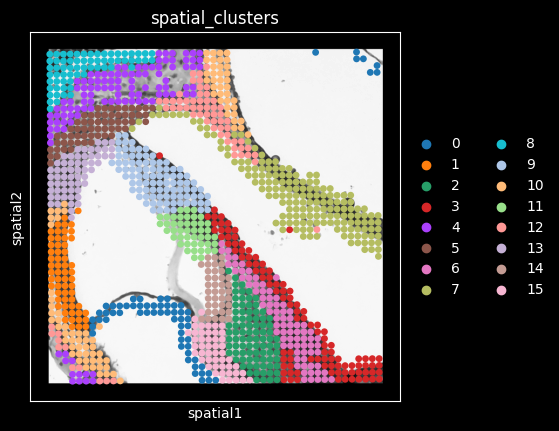

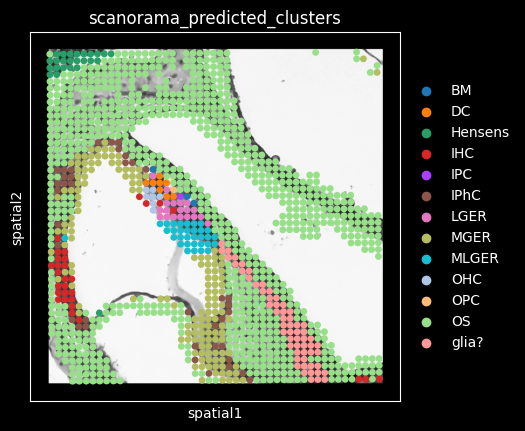

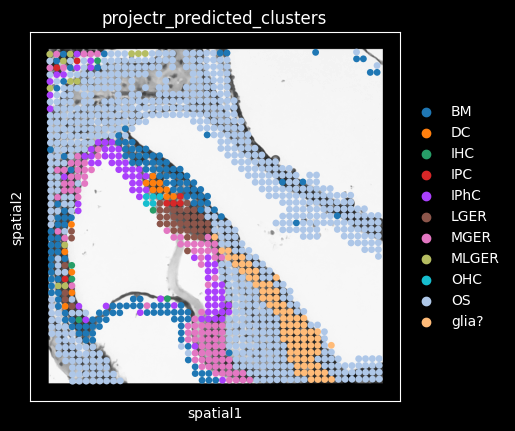

In [672]:
sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", library_id="D1_hires_image", bw=True)
sc.pl.spatial(vis_adata, img_key="hires", color="scanorama_predicted_clusters", library_id="D1_hires_image", bw=True)
sc.pl.spatial(vis_adata, img_key="hires", color="projectr_predicted_clusters", library_id="D1_hires_image", bw=True)


In [664]:
vis_adata.obs.value_counts("spatial_clusters")

spatial_clusters
7     165
4     108
3     101
9      93
2      86
10     85
6      77
12     65
8      64
0      61
5      60
1      59
13     59
15     48
11     45
14     39
Name: count, dtype: int64

In [665]:
vis_adata.obs.value_counts("scanorama_predicted_clusters")

scanorama_predicted_clusters
OS         845
MGER       148
glia?       58
IPhC        39
MLGER       32
IHC         29
Hensens     25
LGER        19
DC           8
OHC          7
BM           3
IPC          1
OPC          1
Name: count, dtype: int64

In [666]:
vis_adata.obs.value_counts("projectr_predicted_clusters")

projectr_predicted_clusters
OS       722
BM       153
MGER     101
IPhC      78
glia?     78
LGER      39
DC        14
MLGER     12
IPC        7
IHC        6
OHC        5
Name: count, dtype: int64

Filtered rank genes projectR predicted clusters

projectr_predicted_clusters
Mes_Cells_1                     35113
Glial_Cells                      4379
Supporting_Cells                 1468
Pf4+_Cells                       1119
Mes_Cells_2                       850
Rgs5+_Cells                       634
Vascular_Cells                    453
Non-Sensory_Epithelial_Cells      280
Type_1_HCs                        213
Otor+_Cells                       175
Type_2_HCs                          3
Name: count, dtype: int64
